In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_pickle('/content/gdrive/MyDrive/malaya_fake_news_preprocessed_dataframe.pkl')

In [ ]:
df=df.head(15000)

In [ ]:
df.shape

(15000, 7)

In [ ]:
df.head()

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

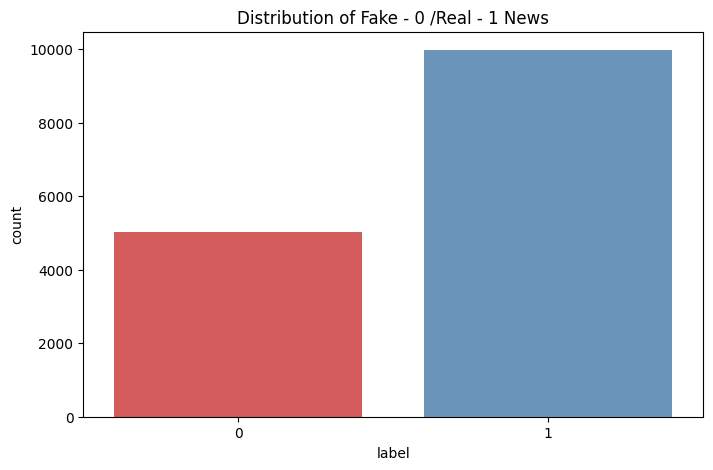

In [ ]:
df['num_words'] = df['news'].apply(lambda x: len(x.split()))
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

In [ ]:
target_count = df.label.value_counts()

In [ ]:
count_class_0, count_class_1 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

Random under-sampling:
1    5028
0    5028
Name: label, dtype: int64


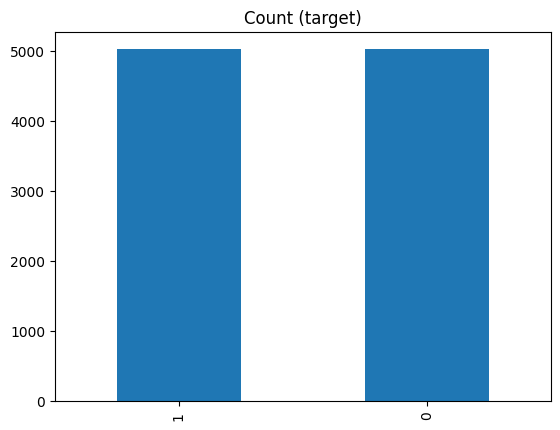

In [ ]:
df_class_1_under = df_class_1.sample(count_class_1)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
#under sampling
print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_under.shape

(10056, 8)

In [ ]:

dfnew=df_test_under[["news","label"]]

In [ ]:
dfnew.head()

,news,label
4524,brie bella mendapatkan keputusan yang mengejut...,1
3150,"paris pada usia donald j trump , brexit dan ke...",1
1426,bekas pengarah fbi james comey bocor lebih ban...,1
5832,dengan hanya beberapa hari lagi pada tahun ini...,1
6582,pujian dari seorang kawan jerman adalah tanda ...,1


In [ ]:
dfnew.shape

(10056, 2)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

SEED = 10

In [ ]:
X=dfnew["news"]
y=dfnew["label"]

In [ ]:

MAX_LEN = 100

def get_model():
    dropout_rate = 0.2

    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')

    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)

    out = Dropout(0.2)(embeddings)

    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)

    y = Dense(1,activation = 'sigmoid')(out)

    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True

    #define optimizer
    optimizer = Adam(learning_rate=1e-05)

    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

    return model

#define tokenization function
def get_tokens(X):

    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = True,
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

    return X

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased",from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


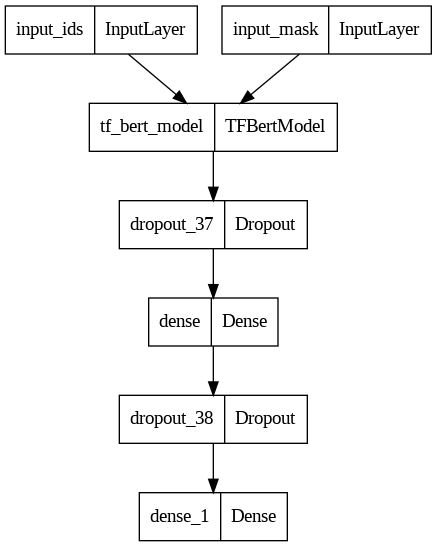

In [ ]:
#plot the model architecture
model = get_model()
tf.keras.utils.plot_model(model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [ ]:
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

history = model.fit(x = {'input_ids':X_train_seq['input_ids'],'input_mask':X_train_seq['attention_mask']},
                    y = y_train, epochs=7,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)],workers=10)

Epoch 1/7
202/202 [==============================] - 224s 861ms/step - loss: 0.5407 - accuracy: 0.7162 - val_loss: 0.3833 - val_accuracy: 0.8247
Epoch 2/7
202/202 [==============================] - 159s 786ms/step - loss: 0.3911 - accuracy: 0.8246 - val_loss: 0.3040 - val_accuracy: 0.8651
Epoch 3/7
202/202 [==============================] - 149s 738ms/step - loss: 0.2725 - accuracy: 0.8875 - val_loss: 0.2856 - val_accuracy: 0.8819
Epoch 4/7
202/202 [==============================] - 157s 779ms/step - loss: 0.2036 - accuracy: 0.9193 - val_loss: 0.2757 - val_accuracy: 0.8856
Epoch 5/7
202/202 [==============================] - 158s 781ms/step - loss: 0.1358 - accuracy: 0.9478 - val_loss: 0.2687 - val_accuracy: 0.9037
Epoch 6/7
202/202 [==============================] - 158s 781ms/step - loss: 0.0966 - accuracy: 0.9622 - val_loss: 0.3356 - val_accuracy: 0.9049
Epoch 7/7
202/202 [==============================] - 158s 780ms/step - loss: 0.0604 - accuracy: 0.9795 - val_loss: 0.4589 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(
    x={'input_ids': X_test_seq['input_ids'], 'input_mask': X_test_seq['attention_mask']},
    y=y_test
)

63/63 [==============================] - 14s 229ms/step - loss: 0.4055 - accuracy: 0.8807


In [ ]:
print("Test loss:", test_loss)
print("Test accuracy",test_accuracy)

Test loss: 0.4055079519748688
Test accuracy 0.8807157278060913


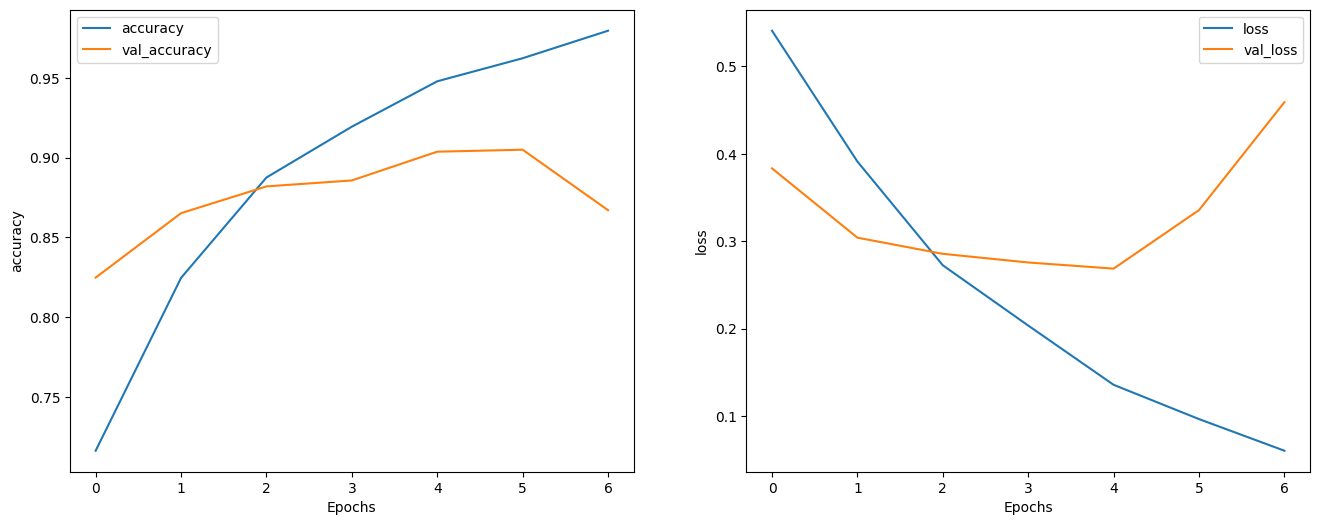

In [ ]:
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
yhat =  np.where(model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']}) >=0.5,1,0)

63/63 [==============================] - 18s 232ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print("precision score:",precision_score(y_test,yhat))
print("recall score:",recall_score(y_test,yhat))
print("accuracy score:",accuracy_score(y_test,yhat))
print("f1 score:",f1_score(y_test,yhat))

precision score: 0.9246119733924612
recall score: 0.8290258449304175
accuracy score: 0.8807157057654076
f1 score: 0.8742138364779873


In [ ]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1006
           1       0.92      0.83      0.87      1006

    accuracy                           0.88      2012
   macro avg       0.88      0.88      0.88      2012
weighted avg       0.88      0.88      0.88      2012



Text(70.72222222222221, 0.5, 'Real Labels')

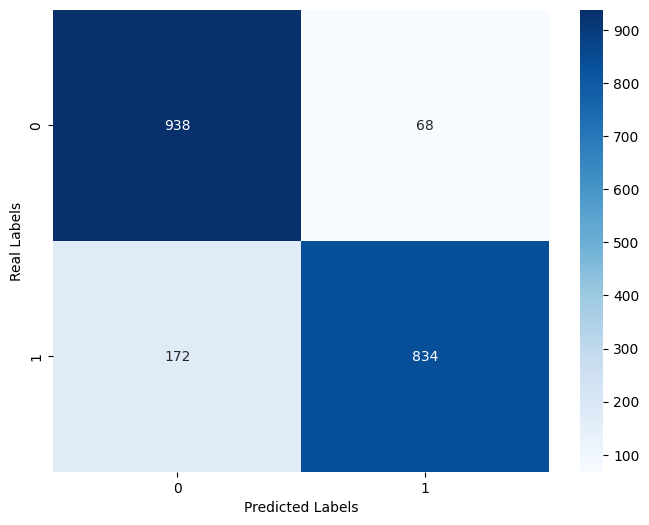

In [ ]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [ ]:
model.save('fake_news_bert_ind.h5')
model.save_weights("fake_news_bert_weights_ind")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
